In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

#this is for importing the sklearn libraries
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN

from skimage.feature import canny
from scipy import ndimage as ndi
from skimage import morphology

from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io

In [2]:
#loads the image in the color format
original_img=cv2.imread('image/42049.jpg' , 1)
image = np.copy (original_img)
image.shape

(321, 481, 3)

In [3]:
def plot_images (img , title):
    plt.figure(figsize = (10 , 10))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([]) 
    plt.title (title)

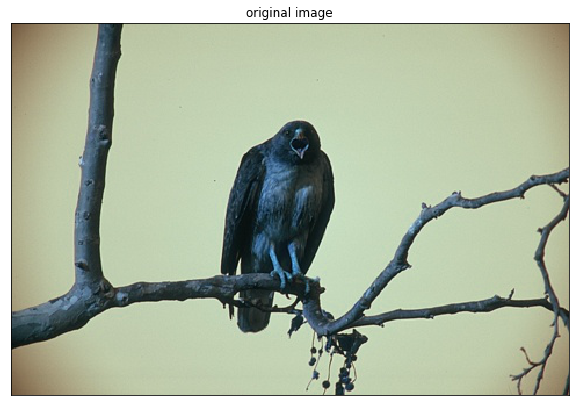

In [4]:
plot_images(image , "original image")

/home/wheezy/anaconda3/lib/python3.6/site-packages/skimage/segmentation/slic_superpixels.py:156: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_z = grid_z[slices]
/home/wheezy/anaconda3/lib/python3.6/site-packages/skimage/segmentation/slic_superpixels.py:157: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_y = grid_y[slices]
/home/wheezy/anaconda3/lib/python3.6/site-packages/skimage/segmentation/slic_superpixels.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq

2 0
79 0
159 0
4319 0


<Figure size 432x288 with 0 Axes>

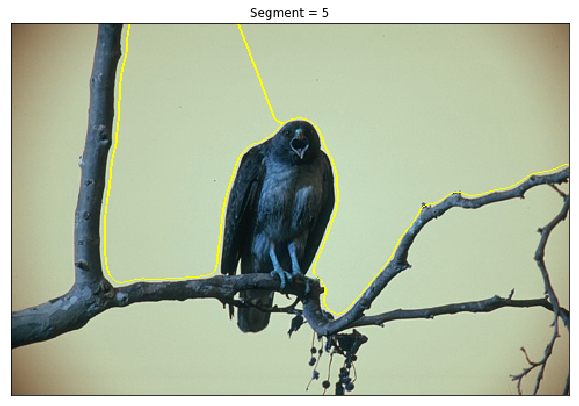

<Figure size 432x288 with 0 Axes>

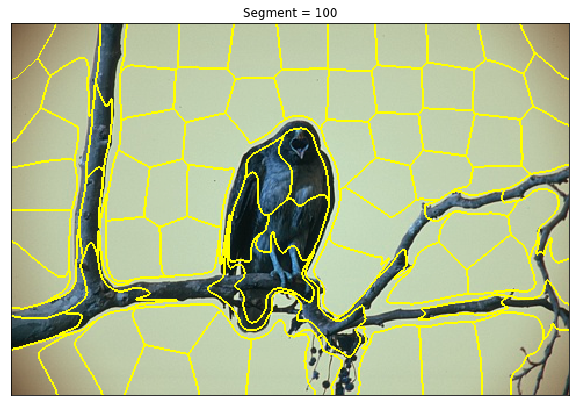

<Figure size 432x288 with 0 Axes>

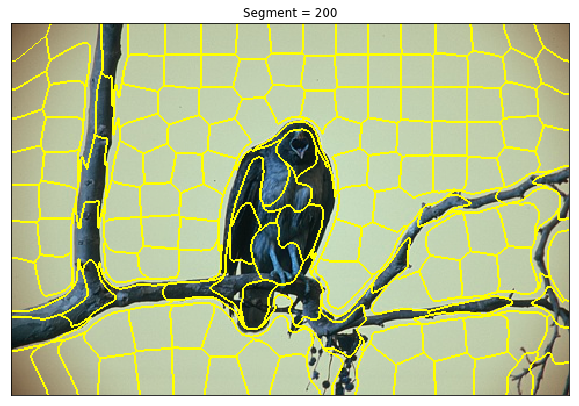

<Figure size 432x288 with 0 Axes>

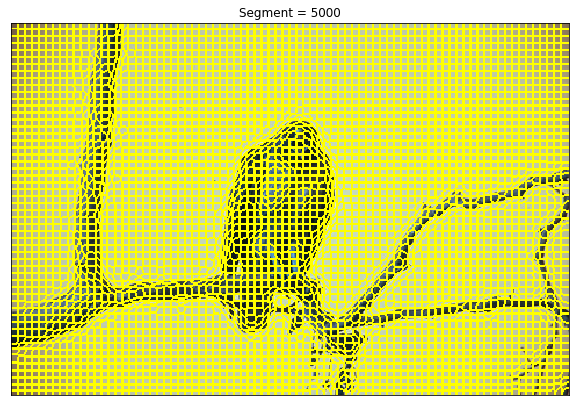

In [5]:
#creating the segmented images
# loop over the number of segments
for numSegments in (5 , 100, 200, 5000):
    # apply SLIC and extract (approximately) the supplied number
    # of segments
    segments = slic(image, n_segments = numSegments, sigma = 5)
    print(np.max(segments) ,np.min(segments))
    # show the output of SLIC
    fig = plt.figure("Superpixels -- %d segments" % (numSegments))
    plot_images(mark_boundaries(image, segments) , "Segment = " + str(numSegments))
    
 
# show the plots
plt.show()

Shape of image segmentation :  (321, 481)
Min of segment is : 0
Max of segment is :  4319
Shape of segment center :  (4320, 3)


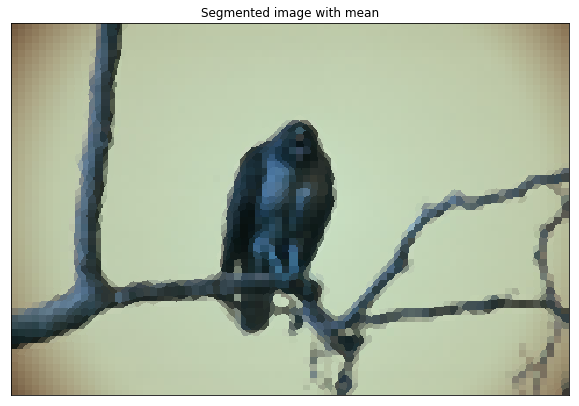

In [6]:
print("Shape of image segmentation : " , segments.shape)
print("Min of segment is :" , np.min(segments))
print("Max of segment is : ", np.max(segments))


segmented_image = np.zeros(image.shape)
segment_center = np.zeros((0 , 3))

for (i , segval) in enumerate(np.unique(segments)):
    mean = np.mean(image[segments == segval] , axis = 0)    
    segmented_image[segments == segval] = mean
    segment_center = np.vstack([segment_center , mean])
    
plot_images(segmented_image/255 , "Segmented image with mean")
print("Shape of segment center : " , segment_center.shape)

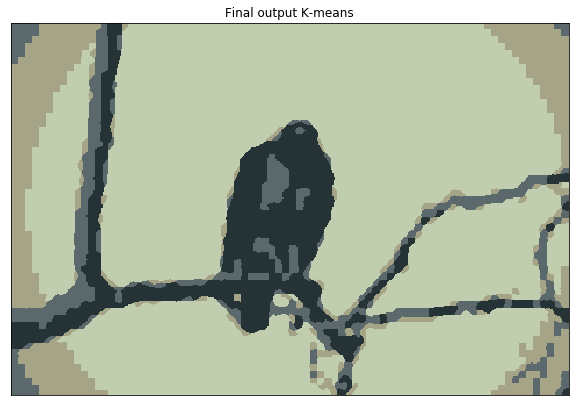

In [7]:
#use the clustering algorithms to cluster the segmented center
cluster = KMeans(n_clusters= 4)
cluster.fit(segment_center)
cluster_centers = cluster.cluster_centers_
cluster_labels = cluster.labels_

#reconstructing the image
cluster_center_value = np.zeros((cluster_labels.shape[0] , 3))
for i in range(cluster_labels.shape[0]):
    cluster_center_value[i] = cluster_centers[cluster_labels[i]]

final_image = np.zeros(image.shape)
for (i , segval) in enumerate(np.unique(segments)):
    final_image[segments == segval] = cluster_center_value[i]

plot_images(final_image/255 , "Final output K-means")

Text(0,0.5,'Cluster distance')

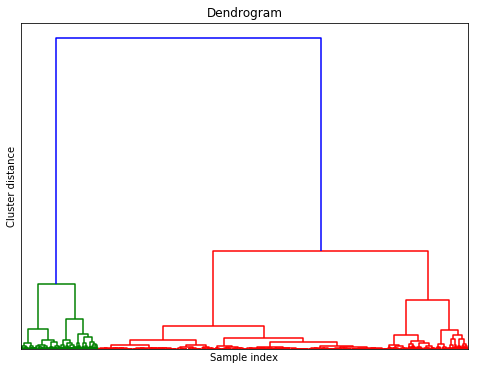

In [8]:
#this is for plotting the dendrogram
from scipy.cluster.hierarchy import dendrogram , ward
linkage_array = ward(segment_center)

#this is to plot the dendrogram
plt.figure(figsize = (8 , 6))
dendrogram (linkage_array)


plt.xticks([])
plt.yticks([])
plt.title("Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")



In [9]:

#now use the agglomerative clustering
n_clusters = 4
cluster_agglo = AgglomerativeClustering(n_clusters= n_clusters)
cluster_agglo.fit(segment_center)
cluster_labels = cluster_agglo.labels_
print(cluster_labels.shape)


(4320,)


(4, 3)


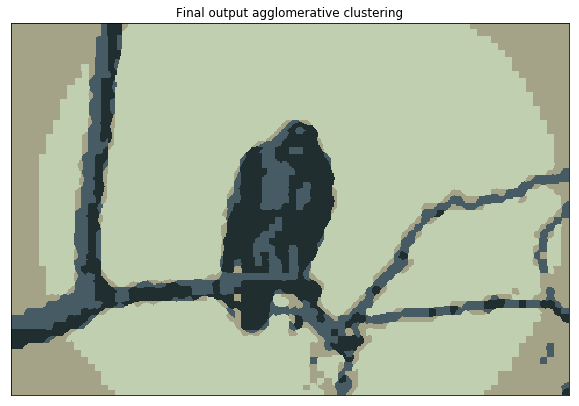

In [10]:
#now this is the reconstruction of the images from the agglomerative clustering part
cluster_centers = np.zeros((n_clusters , 3))
#first find the cluster centers
for i in range(n_clusters):
    cluster_centers[i] = np.mean(segment_center[cluster_labels == i] , axis = 0)

print(cluster_centers.shape)

#reconstruction of the segmented image
#final reconstruction of the image
cluster_center_value = np.zeros((cluster_labels.shape[0] , 3))
for i in range(cluster_labels.shape[0]):
    cluster_center_value[i] = cluster_centers[cluster_labels[i]]

final_image = np.zeros(image.shape)
for (i , segval) in enumerate(np.unique(segments)):
    final_image[segments == segval] = cluster_center_value[i]
    
plot_images(final_image/255 , "Final output agglomerative clustering")

(4320,)
Number of clusters :  21
bin values :  [ 196 3436  448   17   60    7   24    6    4    7   26   14    7    6
   16    8    8   10    6    3    5    6]


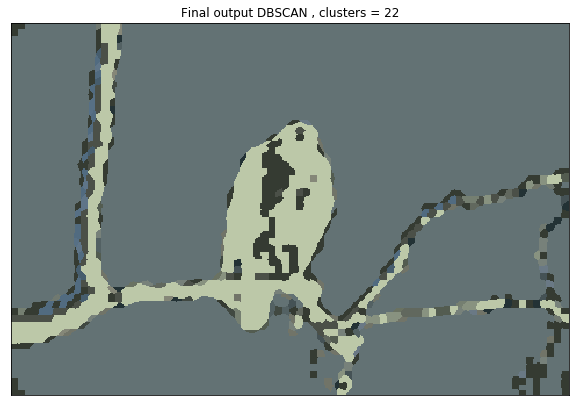

In [11]:
#this is with the spectral clusterin
cluster_dbscan = DBSCAN(eps = 5)
cluster_dbscan.fit(segment_center)
cluster_labels = cluster_dbscan.labels_
print(cluster_labels.shape)
print("Number of clusters : " , np.max(cluster_labels) + 1)
print("bin values : " , np.bincount(cluster_labels + 1))

#now this is the reconstruction of the images from the DBSCAN part

n_clusters = np.max(cluster_labels) + 2
cluster_centers = np.zeros((n_clusters , 3))
#first find the cluster centers
for i in range(n_clusters):
    cluster_centers[i] = np.mean(segment_center[cluster_labels == i-1] , axis = 0)

#final reconstruction of the image
cluster_center_value = np.zeros((cluster_labels.shape[0] , 3))
for i in range(cluster_labels.shape[0]):
    cluster_center_value[i] = cluster_centers[cluster_labels[i]]

final_image = np.zeros(image.shape)
for (i , segval) in enumerate(np.unique(segments)):
    final_image[segments == segval] = cluster_center_value[i]
    
plot_images(final_image/255 , "Final output DBSCAN , clusters = " + str(n_clusters) )